In [1]:
%load_ext autoreload

from dotenv import load_dotenv

# Load environment variables from .env file
load_dotenv("../.env")

True

In [2]:
%autoreload 2

import json
from pathlib import Path

import geopandas as gpd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

from estuary.model.data import parse_dt_from_pth

In [4]:
skipped_regions = pd.read_csv("/Volumes/x10pro/estuary/geos/skipped_regions.csv")[
    "Site code"
].to_list()

gdf = gpd.read_file("/Users/kyledorman/data/estuary/geos/ca_data_w_usgs.geojson")
gdf = gdf[~gdf["Site code"].isin(skipped_regions)].copy()
gdf = gdf.set_index("Site code")
gdf.head()

,Latitude,Longitude,Region,Nation,Site name,Studied (1) / Not Studied (0),station_nm,site_no,site_latitude,site_longitude,geometry
Site code,,,,,,,,,,,
11,32.933,-117.260,North America,USA,Los Penasquitos Lagoon,1,None,None,None,None,POINT (-117.26 32.933)
12,33.166,-117.358,North America,USA,Buena Vista Lagoon,0,None,None,None,None,POINT (-117.358 33.166)
14,33.203,-117.391,North America,USA,San Luis Rey River,0,None,None,None,None,POINT (-117.391 33.203)
15,33.231,-117.416,North America,USA,Santa Margarita River,1,SANTA MARGARITA RIVER ESTUARY NR OCEANSIDE CA,11046050,33.2294795,-117.4103174,POINT (-117.416 33.231)
16,33.291,-117.465,North America,USA,Las Fores Creek,0,LAS FLORES C LAGOON A MOUTH NR OCEANSIDE CA,11046102,33.29055556,-117.465,POINT (-117.465 33.291)


In [5]:
with open("/Users/kyledorman/data/estuary/geos/ca_empa_matching_sites.json") as f:
    matching_sites = json.load(f)

matching_sites

{'11': 'SC-LPL',
 '18': 'SC-ZUM',
 '21': 'SC-VEN',
 '25': 'SC-DEV',
 '28': 'SC-GOL',
 '43': 'CC-ADLC',
 '48': 'CC-CAR',
 '50': 'CC-SALI',
 '51': 'CC-PAJ',
 '72': 'NC-RUSR',
 '84': 'NC-NAV',
 '2145': 'SC-MAL',
 '2161': 'SC-MUGU',
 '2162': 'SC-SDL',
 '2163': 'SC-TJES'}

In [5]:
empa = pl.read_csv("/Volumes/x10pro/estuary/ca_all/empa/logger-raw-publish.csv")
# define time parsing (try multiple formats)
parsed_dt = pl.coalesce(
    [
        pl.col("samplecollectiontimestamp").str.strptime(
            pl.Datetime, "%d/%m/%Y %H:%M:%S", strict=False
        ),
        pl.col("samplecollectiontimestamp").str.strptime(
            pl.Datetime, "%d/%m/%Y %H:%M:%S%.f", strict=False
        ),
    ]
)

# offsets relative to UTC (Polars doesn’t know “PST/PDT” by name)
# PST = UTC−8, PDT = UTC−7
empa = empa.with_columns([parsed_dt.alias("samplecollectiontimestamp_parsed")])

# apply offset based on timezone
empa = empa.with_columns(
    [
        pl.when(pl.col("samplecollectiontimezone") == "PST")
        .then(pl.col("samplecollectiontimestamp_parsed") + pl.duration(hours=8))  # PST -> UTC
        .when(pl.col("samplecollectiontimezone") == "PDT")
        .then(pl.col("samplecollectiontimestamp_parsed") + pl.duration(hours=7))  # PDT -> UTC
        .when(pl.col("samplecollectiontimezone") == "UTC")
        .then(pl.col("samplecollectiontimestamp_parsed"))
        .otherwise(pl.col("samplecollectiontimestamp_parsed"))
        .alias("samplecollectiontimestamp_utc2")
    ]
)
empa = empa.filter(pl.col("siteid").is_in(list(matching_sites.values())))
empa.head()

objectid,projectid,siteid,estuaryname,stationno,sensortype,sensorid,samplecollectiontimestamp,samplecollectiontimezone,raw_depth,raw_depth_unit,raw_depth_qcflag,raw_pressure,raw_pressure_unit,raw_pressure_qcflag,raw_h2otemp,raw_h2otemp_unit,raw_h2otemp_qcflag,raw_ph,raw_ph_qcflag,raw_conductivity,raw_conductivity_unit,raw_conductivity_qcflag,raw_turbidity,raw_turbidity_unit,raw_turbidity_qcflag,raw_do,raw_do_unit,raw_do_qcflag,raw_do_pct,raw_do_pct_qcflag,raw_salinity,raw_salinity_unit,raw_salinity_qcflag,raw_chlorophyll,raw_chlorophyll_unit,raw_chlorophyll_qcflag,raw_orp,raw_orp_unit,raw_orp_qcflag,raw_qvalue,raw_qvalue_qcflag,samplecollectiontimestamp_utc,raw_atmospheric_pressure,raw_atmospheric_pressure_unit,raw_atmospheric_pressure_qcflag,qaqc_comment,wqnotes,sensorlocation,organization,samplecollectiontimestamp_parsed,samplecollectiontimestamp_utc2
i64,str,str,str,i64,str,str,str,str,str,str,i64,f64,str,i64,f64,str,i64,str,i64,f64,str,i64,str,str,i64,str,str,i64,str,i64,f64,str,i64,str,str,i64,str,str,i64,str,i64,str,str,str,str,str,str,str,str,datetime[μs],datetime[μs]
1428135,"""EMPA""","""CC-ADLC""","""Arroyo de la Cruz""",1,"""CTD""","""X1700""","""31/3/2021 19:24:00""","""UTC""",null,"""Not Recorded""",4,1166.5,"""cmH2O""",4,15.93,"""deg C""",4,null,4,0.98,"""mS/cm""",4,null,"""Not Recorded""",4,null,"""Not Recorded""",4,null,4,0.589121,"""ppt""",4,null,"""Not Recorded""",4,null,"""Not Recorded""",4,null,4,"""31/3/2021 19:24:00""",null,null,null,null,null,null,null,2021-03-31 19:24:00,2021-03-31 19:24:00
1428136,"""EMPA""","""CC-ADLC""","""Arroyo de la Cruz""",1,"""CTD""","""X1700""","""31/3/2021 19:30:00""","""UTC""",null,"""Not Recorded""",4,1166.85,"""cmH2O""",4,16.07,"""deg C""",4,null,4,1.044,"""mS/cm""",4,null,"""Not Recorded""",4,null,"""Not Recorded""",4,null,4,0.627551,"""ppt""",4,null,"""Not Recorded""",4,null,"""Not Recorded""",4,null,4,"""31/3/2021 19:30:00""",null,null,null,null,null,null,null,2021-03-31 19:30:00,2021-03-31 19:30:00
1428137,"""EMPA""","""CC-ADLC""","""Arroyo de la Cruz""",1,"""CTD""","""X1700""","""31/3/2021 19:36:00""","""UTC""",null,"""Not Recorded""",4,1167.141667,"""cmH2O""",4,16.053333,"""deg C""",4,null,4,1.064,"""mS/cm""",4,null,"""Not Recorded""",4,null,"""Not Recorded""",4,null,4,0.640444,"""ppt""",4,null,"""Not Recorded""",4,null,"""Not Recorded""",4,null,4,"""31/3/2021 19:36:00""",null,null,null,null,null,null,null,2021-03-31 19:36:00,2021-03-31 19:36:00
1428138,"""EMPA""","""CC-ADLC""","""Arroyo de la Cruz""",1,"""CTD""","""X1700""","""31/3/2021 19:42:00""","""UTC""",null,"""Not Recorded""",4,1167.258333,"""cmH2O""",4,16.206667,"""deg C""",4,null,4,1.136,"""mS/cm""",4,null,"""Not Recorded""",4,null,"""Not Recorded""",4,null,4,0.683421,"""ppt""",4,null,"""Not Recorded""",4,null,"""Not Recorded""",4,null,4,"""31/3/2021 19:42:00""",null,null,null,null,null,null,null,2021-03-31 19:42:00,2021-03-31 19:42:00
1428139,"""EMPA""","""CC-ADLC""","""Arroyo de la Cruz""",1,"""CTD""","""X1700""","""31/3/2021 19:48:00""","""UTC""",null,"""Not Recorded""",4,1167.55,"""cmH2O""",4,16.276667,"""deg C""",4,null,4,1.16,"""mS/cm""",4,null,"""Not Recorded""",4,null,"""Not Recorded""",4,null,4,0.697363,"""ppt""",4,null,"""Not Recorded""",4,null,"""Not Recorded""",4,null,4,"""31/3/2021 19:48:00""",null,null,null,null,null,null,null,2021-03-31 19:48:00,2021-03-31 19:48:00


In [6]:
site_ids = empa["siteid"].unique().sort()

for si in site_ids:
    region = next(k for k, v in matching_sites.items() if v == si)
    name = gdf.loc[int(region)]["Site name"]
    print(si, region, name)

CC-ADLC 43 Arroyo De La Laguna
CC-CAR 48 Carmel River
CC-PAJ 51 Pajaro River
NC-NAV 84 Navarro River
SC-GOL 28 San Pedro Creek
SC-MAL 2145 Malibu lagoon
SC-VEN 21 Ventura River


In [7]:
counts = (
    empa.group_by(["siteid", "sensorid"])
    .agg(pl.len().alias("n_samples"))
    .sort(["siteid", "sensorid"])
)

counts

siteid,sensorid,n_samples
str,str,u32
"""CC-ADLC""","""21002884""",13434
"""CC-ADLC""","""21002895""",13207
"""CC-ADLC""","""407089""",1410
"""CC-ADLC""","""593895""",36709
"""CC-ADLC""","""791309""",7344
…,…,…
"""SC-MAL""","""X2274""",62188
"""SC-VEN""","""613068""",54529
"""SC-VEN""","""7450-176117""",8223


shape: (68, 4)
┌─────────┬─────────────┬─────────────────────┬─────────────────────┐
│ siteid  ┆ sensorid    ┆ start               ┆ end                 │
│ ---     ┆ ---         ┆ ---                 ┆ ---                 │
│ str     ┆ str         ┆ datetime[μs]        ┆ datetime[μs]        │
╞═════════╪═════════════╪═════════════════════╪═════════════════════╡
│ CC-ADLC ┆ 21002884    ┆ 2021-03-31 20:06:00 ┆ 2021-05-26 19:24:00 │
│ CC-ADLC ┆ 21002895    ┆ 2021-03-31 21:12:00 ┆ 2021-05-25 21:48:00 │
│ CC-ADLC ┆ 407089      ┆ 2021-03-31 20:06:00 ┆ 2021-04-06 17:00:00 │
│ CC-ADLC ┆ 593895      ┆ 2021-05-25 22:37:00 ┆ 2021-10-25 21:25:00 │
│ CC-ADLC ┆ 791309      ┆ 2023-10-16 12:00:00 ┆ 2023-12-31 23:45:00 │
│ …       ┆ …           ┆ …                   ┆ …                   │
│ SC-MAL  ┆ X2274       ┆ 2023-04-16 13:00:00 ┆ 2023-12-31 23:57:00 │
│ SC-VEN  ┆ 613068      ┆ 2021-11-08 20:37:00 ┆ 2022-06-24 01:25:00 │
│ SC-VEN  ┆ 7450-176117 ┆ 2023-11-04 21:37:00 ┆ 2023-12-31 23:57:00 │
│ SC-

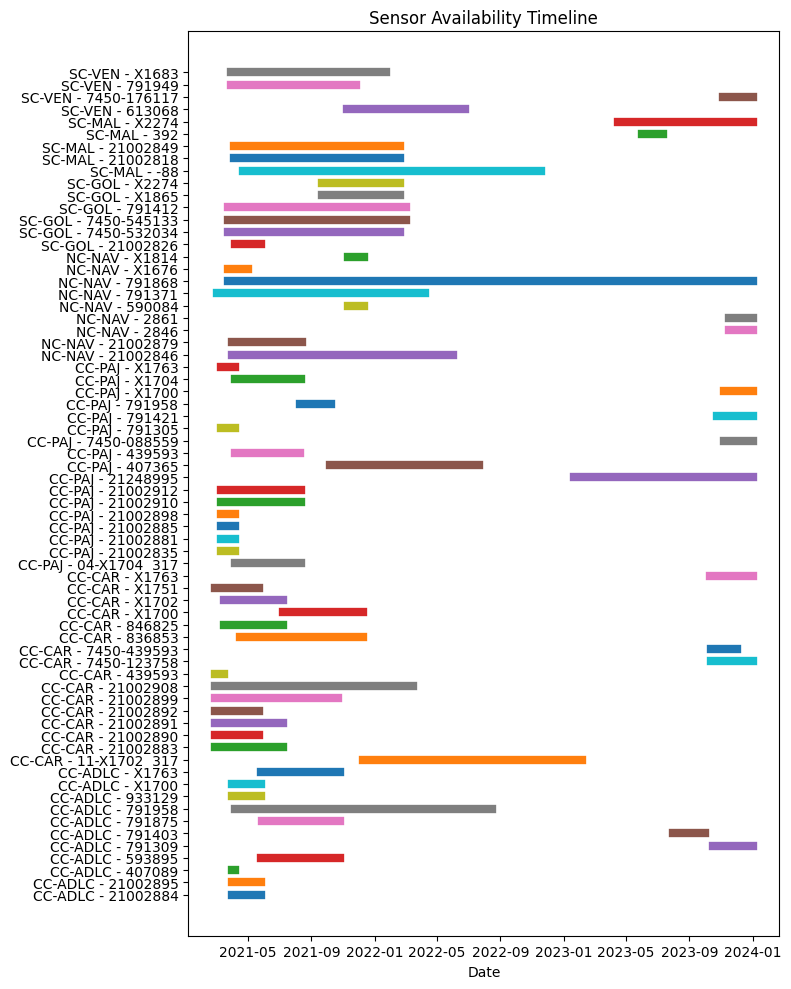

In [8]:
ranges = (
    empa.group_by(["siteid", "sensorid"])
    .agg(
        [
            pl.col("samplecollectiontimestamp_parsed").min().alias("start"),
            pl.col("samplecollectiontimestamp_parsed").max().alias("end"),
        ]
    )
    .sort(["siteid", "sensorid"])
)
print(ranges)

pdf = ranges.to_pandas()

# Combine siteid & sensorid as label
pdf["label"] = pdf["siteid"] + " - " + pdf["sensorid"]

fig, ax = plt.subplots(figsize=(8, 10))
for i, row in pdf.iterrows():
    ax.plot([row["start"], row["end"]], [i, i], lw=6, label=row["label"])

ax.set_yticks(range(len(pdf)))
ax.set_yticklabels(pdf["label"])
ax.set_xlabel("Date")
ax.set_title("Sensor Availability Timeline")
plt.tight_layout()
plt.show()

In [10]:
corr = pl.read_csv("/Volumes/x10pro/estuary/ca_all/empa/logger-raw-depth-correction-publish.csv")
corr = corr.with_columns(
    [
        pl.coalesce(
            [
                pl.col("samplecollectiontimestamp").str.strptime(
                    pl.Datetime, "%d/%m/%Y %H:%M:%S", strict=False
                ),
                pl.col("samplecollectiontimestamp").str.strptime(
                    pl.Datetime, "%d/%m/%Y %H:%M:%S%.f", strict=False
                ),
            ]
        ).alias("samplecollectiontimestamp_parsed")
    ]
)
corr = corr.filter(pl.col("siteid").is_in(list(matching_sites.values())))

corr

objectid,projectid,estuaryname,siteid,stationno,sensortype,sensorid,buoyid,samplecollectiontimestamp,raw_pressure,raw_barometric_pressure,corrected_pressure,corrected_depth,last_edited_date,samplecollectiontimestamp_parsed
i64,str,str,str,i64,str,str,i64,str,f64,f64,f64,f64,str,datetime[μs]
2688,"""EMPA""","""Arroyo de la Cruz""","""CC-ADLC""",1,"""CTD""","""X1700""",9412110,"""11/4/2021 23:42:00""",1159.733333,1008.4,131.899448,1.31989,"""6/3/2025 23:59:29.131228""",2021-04-11 23:42:00
2689,"""EMPA""","""Arroyo de la Cruz""","""CC-ADLC""",1,"""CTD""","""X1700""",9412110,"""11/4/2021 23:48:00""",1159.091667,1008.5,131.155855,1.312449,"""6/3/2025 23:59:29.131228""",2021-04-11 23:48:00
2690,"""EMPA""","""Arroyo de la Cruz""","""CC-ADLC""",1,"""CTD""","""X1700""",9412110,"""11/4/2021 23:54:00""",1158.916667,1008.6,130.878928,1.309677,"""6/3/2025 23:59:29.131228""",2021-04-11 23:54:00
2691,"""EMPA""","""Arroyo de la Cruz""","""CC-ADLC""",1,"""CTD""","""X1700""",9412110,"""12/4/2021 00:00:00""",1158.45,1008.6,130.412261,1.305008,"""6/3/2025 23:59:29.131228""",2021-04-12 00:00:00
2692,"""EMPA""","""Arroyo de la Cruz""","""CC-ADLC""",1,"""CTD""","""X1700""",9412110,"""12/4/2021 00:06:00""",1158.391667,1008.5,130.455855,1.305444,"""6/3/2025 23:59:29.131228""",2021-04-12 00:06:00
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
2683,"""EMPA""","""Arroyo de la Cruz""","""CC-ADLC""",1,"""CTD""","""X1700""",9412110,"""11/4/2021 23:12:00""",1161.133333,1008.6,133.095594,1.331859,"""6/3/2025 23:59:29.131228""",2021-04-11 23:12:00
2684,"""EMPA""","""Arroyo de la Cruz""","""CC-ADLC""",1,"""CTD""","""X1700""",9412110,"""11/4/2021 23:18:00""",1160.9,1008.5,132.964188,1.330544,"""6/3/2025 23:59:29.131228""",2021-04-11 23:18:00
2685,"""EMPA""","""Arroyo de la Cruz""","""CC-ADLC""",1,"""CTD""","""X1700""",9412110,"""11/4/2021 23:24:00""",1160.433333,1008.5,132.497521,1.3258743,"""6/3/2025 23:59:29.131228""",2021-04-11 23:24:00


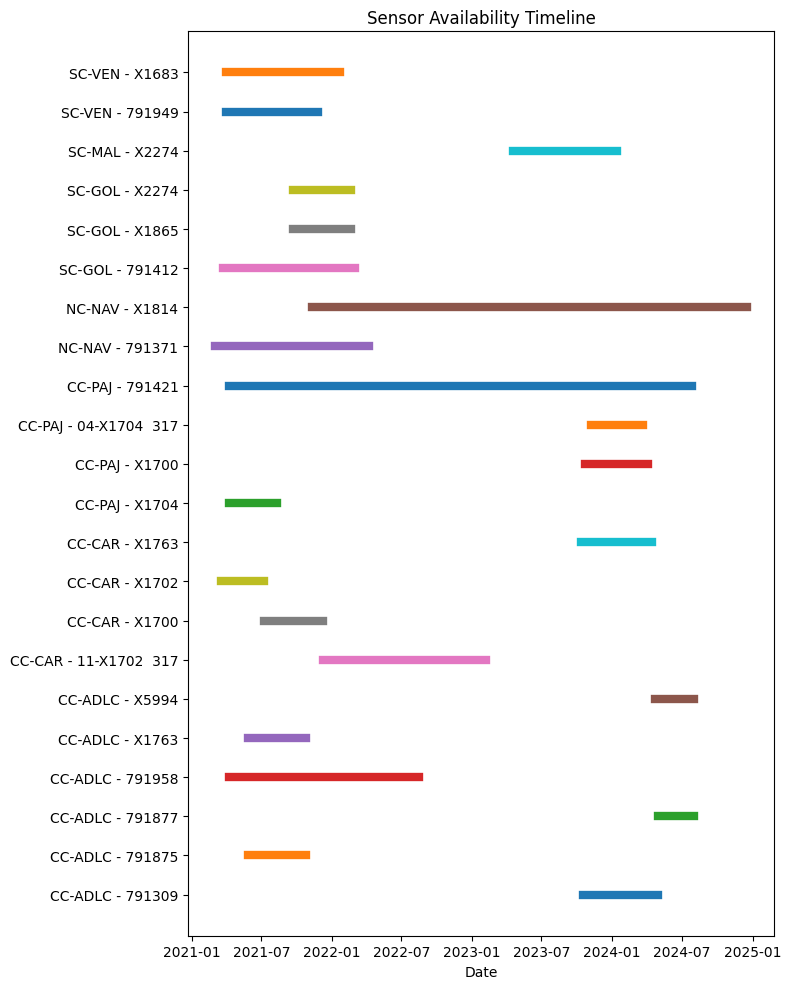

In [11]:
ranges = (
    corr.group_by(["siteid", "sensorid"])
    .agg(
        [
            pl.col("samplecollectiontimestamp_parsed").min().alias("start"),
            pl.col("samplecollectiontimestamp_parsed").max().alias("end"),
        ]
    )
    # Filter groups where (end - start) > 90 days
    .filter((pl.col("end") - pl.col("start")) > pl.duration(days=90))
    .sort(["siteid", "sensorid"])
)
# print(ranges)

pdf = ranges.to_pandas()
pdf = pdf.sort_values(by="siteid")

# Combine siteid & sensorid as label
pdf["label"] = pdf["siteid"] + " - " + pdf["sensorid"]

fig, ax = plt.subplots(figsize=(8, 10))
for i, row in pdf.iterrows():
    ax.plot([row["start"], row["end"]], [i, i], lw=6, label=row["label"])

ax.set_yticks(range(len(pdf)))
ax.set_yticklabels(pdf["label"])
ax.set_xlabel("Date")
ax.set_title("Sensor Availability Timeline")
plt.tight_layout()
plt.show()

In [15]:
preds_all = pd.read_csv(Path("/Volumes/x10pro/estuary/ca_all/") / "preds.csv")
preds_all["acquired"] = preds_all["source_tif"].apply(lambda p: parse_dt_from_pth(Path(p)))
preds_all

,source_tif,y_true,y_prob,y_pred,region,dataset,orig_label,correct,acquired
0,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.999900,1,84,train,open,True,2017-02-27 18:18:07
1,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.999939,1,84,train,open,True,2017-03-11 18:18:41
2,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.999023,1,84,train,open,True,2017-03-29 18:10:56
3,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.999670,1,84,train,open,True,2017-04-18 18:12:17
4,/Volumes/x10pro/estuary/ca_all/dove/results/20...,1,0.999163,1,84,train,open,True,2017-04-29 18:12:11
...,...,...,...,...,...,...,...,...,...
8108,/Volumes/x10pro/estuary/ca_all/superdove/resul...,0,0.000078,0,43,train,closed,True,2025-09-03 19:13:13
8109,/Volumes/x10pro/estuary/ca_all/superdove/resul...,0,0.000095,0,43,train,closed,True,2025-09-05 19:23:57
8110,/Volumes/x10pro/estuary/ca_all/superdove/resul...,0,0.000061,0,43,train,closed,True,2025-09-06 19:23:10
8111,/Volumes/x10pro/estuary/ca_all/superdove/resul...,0,0.000448,0,43,train,closed,True,2025-09-11 19:11:36


In [31]:
a = empa.filter((pl.col("siteid") == "SC-VEN") & (pl.col("sensorid") == "X1683"))[
    ["samplecollectiontimestamp_utc2", "raw_h2otemp", "raw_conductivity"]
].to_pandas()
a["raw_h2otemp"] = a["raw_h2otemp"].apply(pd.to_numeric)
a["raw_conductivity"] = a["raw_conductivity"].apply(pd.to_numeric)
a = a.rename(columns={"samplecollectiontimestamp_utc2": "acquired"})

b = corr.filter((pl.col("siteid") == "SC-VEN") & (pl.col("sensorid") == "X1683"))[
    ["samplecollectiontimestamp_parsed", "corrected_depth"]
].to_pandas()
b["corrected_depth"] = b["corrected_depth"].apply(pd.to_numeric)

b = b.rename(columns={"samplecollectiontimestamp_parsed": "acquired"})

pd.merge(a, b, on="acquired", how="outer").raw_conductivity.isna().sum()

0

In [33]:
pd.merge(a, b, on="acquired", how="outer").isna().any(axis=1)

0        False
1        False
2        False
3        False
4        False
         ...  
71727    False
71728    False
71729    False
71730    False
71731    False
Length: 71732, dtype: bool

In [ ]:
def _find_gaps(
    df_time_sorted,
    time_col="acquired",
    min_gap=pd.Timedelta(days=2.5),
    edge_buffer=pd.Timedelta(hours=6),
):
    """
    Return a list of (gap_start, gap_end) where time delta between consecutive
    samples exceeds `min_gap`. Each interval is trimmed by `edge_buffer` on both ends.
    """
    t = df_time_sorted[time_col].values
    if len(t) < 2:
        return []

    # compute diffs
    ts = df_time_sorted[time_col].reset_index(drop=True)
    d = ts.diff()

    gaps = []
    for i in range(1, len(ts)):
        if d.iloc[i] > min_gap:
            start_raw = ts.iloc[i - 1]
            end_raw = ts.iloc[i]

            # dynamic safety: don’t over-trim for short-but-qualifying gaps
            # use the smaller of requested buffer and 10% of gap
            dyn_buf = min(edge_buffer, (end_raw - start_raw) / 10)

            start = start_raw + dyn_buf
            end = end_raw - dyn_buf
            if start < end:
                gaps.append((start, end))
    return gaps


def plot_metric(sdf, col, site, save=False):
    # preds_all: ['acquired','y_true','y_prob','y_pred','region']
    # sdf:       ['acquired', col]
    preds_all_plot = preds_all[preds_all.region == site].copy()
    sdf_plot = sdf.copy()

    # normalize times
    preds_all_plot["acquired"] = (
        pd.to_datetime(preds_all_plot["acquired"], errors="coerce", utc=True)
        .dt.tz_convert("UTC")
        .dt.tz_localize(None)
        .astype("datetime64[ns]")
    )
    sdf_plot["acquired"] = (
        pd.to_datetime(sdf_plot["acquired"], errors="coerce", utc=True)
        .dt.tz_convert("UTC")
        .dt.tz_localize(None)
        .astype("datetime64[ns]")
    )
    preds_all_plot = preds_all_plot.sort_values("acquired").dropna(subset=["acquired"])
    sdf_plot = (
        sdf_plot.sort_values("acquired")
        .dropna(subset=["acquired"])
        .drop_duplicates(subset="acquired", keep="first")
    )

    # keep preds within depth time span
    if not sdf_plot.empty:
        preds_all_plot = preds_all_plot[
            (preds_all_plot.acquired >= sdf_plot.acquired.min())
            & (preds_all_plot.acquired <= sdf_plot.acquired.max())
        ]

    def find_state_changes(df, state_col, include_first=True):
        s = df[state_col].astype("int64")
        changed = s.ne(s.shift(1))
        if not include_first and len(changed):
            changed.iloc[0] = False
        return df.loc[changed, ["acquired", state_col]].rename(columns={state_col: "new_state"})

    # change points
    true_changes = find_state_changes(preds_all_plot, "y_true", include_first=True)
    pred_changes = find_state_changes(preds_all_plot, "y_pred", include_first=True)

    # nearest join to grab metric value at change times
    true_cp = pd.merge_asof(
        true_changes.sort_values("acquired"),
        sdf_plot.sort_values("acquired"),
        on="acquired",
        direction="nearest",
    )
    pred_cp = pd.merge_asof(
        pred_changes.sort_values("acquired"),
        sdf_plot.sort_values("acquired"),
        on="acquired",
        direction="nearest",
    )

    # --- compute data gaps from the metric series once; reuse for both plots ---
    gaps = _find_gaps(
        preds_all_plot[["acquired"]].sort_values("acquired"),
        time_col="acquired",
        min_gap=pd.Timedelta(days=4.5),
        edge_buffer=pd.Timedelta(hours=12),
    )  # tweak as you like

    def format_time_axis(ax):
        ax.xaxis.set_major_locator(mdates.AutoDateLocator())
        ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

    # -------- Plot 1: labels --------
    fig1, ax1 = plt.subplots(figsize=(11, 4))
    ax1.plot(sdf_plot["acquired"], sdf_plot[col], lw=1.5, color="k")
    ax1.set_title(f"{col} with LABEL State Changes (y_true)")
    ax1.set_xlabel("Time")
    ax1.set_ylabel(col)

    # blue filled bands for gaps (solid, not dashed)
    for start, end in gaps:
        ax1.axvspan(start, end, color="blue", alpha=0.15, linewidth=0)

    for _, row in true_cp.iterrows():
        color = "green" if int(row["new_state"]) == 1 else "red"
        ax1.axvline(row["acquired"], linestyle="--", color=color, alpha=0.8, linewidth=1.25)
        ax1.scatter(row["acquired"], row[col], color=color, s=35, zorder=3)

    format_time_axis(ax1)
    fig1.tight_layout()
    if save:
        plt.savefig(f"/Users/kyledorman/data/estuary/display/malibu_{col}_label.png", dpi=200)

    # -------- Plot 2: predictions --------
    fig2, ax2 = plt.subplots(figsize=(11, 4))
    ax2.plot(sdf_plot["acquired"], sdf_plot[col], lw=1.5, color="k")
    ax2.set_title(f"{col} with PREDICTED State Changes (y_pred)")
    ax2.set_xlabel("Time")
    ax2.set_ylabel(col)

    for start, end in gaps:
        ax2.axvspan(start, end, color="blue", alpha=0.15, linewidth=0)

    for _, row in pred_cp.iterrows():
        color = "green" if int(row["new_state"]) == 1 else "red"
        ax2.axvline(row["acquired"], linestyle="--", color=color, alpha=0.8, linewidth=1.25)
        ax2.scatter(row["acquired"], row[col], color=color, s=35, zorder=3)

    format_time_axis(ax2)
    fig2.tight_layout()
    if save:
        plt.savefig(f"/Users/kyledorman/data/estuary/display/malibu_{col}_pred.png", dpi=200)

    plt.show()

In [ ]:
aaa = (
    empa.filter((pl.col("siteid") == "SC-VEN") & (pl.col("sensorid") == "X1683"))[
        [
            "raw_depth",
            "raw_pressure",
            "raw_h2otemp",
            "raw_ph",
            "raw_conductivity",
            "raw_turbidity",
            "raw_do",
            "raw_salinity",
            "sensorid",
            "sensortype",
            "samplecollectiontimestamp_parsed",
        ]
    ]
    .to_pandas()
    .rename(columns={"samplecollectiontimestamp_parsed": "acquired"})
)

# Ensure the index is datetime, not a column
aaa["acquired"] = pd.to_datetime(aaa.acquired)
aaa = aaa.sort_values(["acquired"])

# aaa = aaa[aaa["acquired"] > pd.Timestamp("2021-09-15")].copy()

aaa["raw_depth"] = aaa["raw_depth"].apply(pd.to_numeric)
aaa["raw_pressure"] = aaa["raw_pressure"].apply(pd.to_numeric)
aaa["raw_h2otemp"] = aaa["raw_h2otemp"].apply(pd.to_numeric)
aaa["raw_ph"] = aaa["raw_ph"].apply(pd.to_numeric).clip(6, 100)
aaa["raw_conductivity"] = aaa["raw_conductivity"].apply(pd.to_numeric)
aaa["raw_turbidity"] = aaa["raw_turbidity"].apply(pd.to_numeric)
aaa["raw_do"] = aaa["raw_do"].apply(pd.to_numeric)
aaa["raw_salinity"] = aaa["raw_salinity"].apply(pd.to_numeric)

aaa

In [ ]:
plot_metric(aaa, "raw_pressure", 21, save=False)

In [ ]:
cc = counts.filter(pl.col("siteid") == "SC-VEN").to_pandas()
cc.sort_values("n_samples").head(11)